# Segmentez des clients d'un site e-commerce

Dans ce notebook, on va effectuer une segmentation des clients. <br>
Il se divisera en :
- Segmentation,
- Importation dans un nouveau fichier "csv".

## Sommaire :
* [1. Importation des librairies](#chapter1)
* [2. Ouverture de fichiers](#chapter2)
* [3. RFM](#chapter3)
* [4. Conclusion](#chapter4)

## 1. Importation des librairies <a class="anchor" id="chapter1"></a>

In [1]:
# Librairies de bases
import pandas as pd
import numpy as np

# Graphique
import matplotlib.pyplot as plt
import seaborn as sns

# RFM
from datetime import timedelta

# Gestion des valeurs manquantes
from sklearn.impute import SimpleImputer

# Mes fonctions
from P5_05_function import *

## 2. Ouverture de fichiers <a class="anchor" id="chapter2"></a>

In [2]:
df = pd.read_csv("notebookexploration.csv")
df.head(3)

,customer_id,customer_unique_id,customer_city,geolocation_lat,geolocation_lng,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,seller_id,product_category_name_english
0,05b005e82f3f2dcc41b5504f00484e50,3ef8c1513fc80fb905ccd8d57da5e9b8,sao paulo,-23.545621,-46.639292,delivered,2018-08-17 10:59:04.000000000,2018-08-18 03:09:46.000000000,2018-08-20 13:43:00.000000000,2018-08-21 17:51:40.000000000,2018-08-22 00:00:00.000000000,1.0,boleto,1.0,33.34,2953ce3a88f5e3c3b696d77fc9e4c8eb,books_technical
1,1d9d8fdfda9ee5c0fbbc6b93e2ceca65,cb382a3e0fbce8a1d31e86f807314dc8,sao paulo,-23.640619,-46.696566,delivered,2018-08-17 08:30:51.000000000,2018-08-18 02:49:48.000000000,2018-08-20 13:49:00.000000000,2018-08-21 18:12:52.000000000,2018-08-22 00:00:00.000000000,1.0,boleto,1.0,33.34,2953ce3a88f5e3c3b696d77fc9e4c8eb,books_technical
2,00ba72dac5dae2776b5bfcf799a956b2,40b5e9eed4db7f956359145971056f5d,sao paulo,-23.738264,-46.701857,delivered,2018-08-11 22:06:23.000000000,2018-08-14 04:30:21.000000000,2018-08-14 15:58:00.000000000,2018-08-16 21:38:54.000000000,2018-08-16 00:00:00.000000000,1.0,boleto,1.0,33.34,2953ce3a88f5e3c3b696d77fc9e4c8eb,books_technical


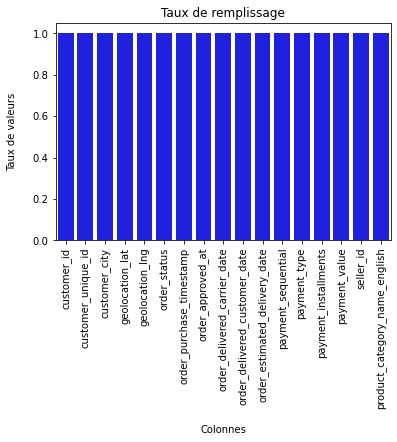

In [3]:
graphRemplissage(df)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_id                    99441 non-null  object 
 1   customer_unique_id             99441 non-null  object 
 2   customer_city                  99441 non-null  object 
 3   geolocation_lat                99441 non-null  float64
 4   geolocation_lng                99441 non-null  float64
 5   order_status                   99441 non-null  object 
 6   order_purchase_timestamp       99441 non-null  object 
 7   order_approved_at              99441 non-null  object 
 8   order_delivered_carrier_date   99441 non-null  object 
 9   order_delivered_customer_date  99441 non-null  object 
 10  order_estimated_delivery_date  99441 non-null  object 
 11  payment_sequential             99441 non-null  float64
 12  payment_type                   99441 non-null 

In [5]:
df.shape

(99441, 17)

## 3. RFM <a class="anchor" id="chapter3"></a>

On va segmenter nos clients, on utilise RFM. Pour commencer, on va convertir les dates au format "datetime".

In [6]:
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    df[cols] = pd.to_datetime(df[cols],
                              format="%Y-%m-%d", errors="ignore")

On regarde le minimum et le maximum de nos dates.

In [7]:
print('Orders from {} to {}'.format(df["order_purchase_timestamp"].min(),
                                    df["order_purchase_timestamp"].max()))

Orders from 2016-09-04 21:15:19 to 2018-10-17 17:30:18


In [8]:
print('Orders from {} to {}'.format(df["order_delivered_customer_date"].min(),
                                    df["order_delivered_customer_date"].max()))

Orders from 2016-09-30 00:00:00 to 2018-11-12 00:00:00


On segmente nos données, on créait un nouveau dataframe en prenant la variable unique des clients. Les nouvelles variables sont : "Recency" et "Frequency".<br>
"Recency" : le nombre de jours depuis la dernière commande.<br>
"Frequency" : le nombre total de commandes au cours de la dernière période.

In [9]:
df['date'] = df['order_approved_at'].apply(lambda x: (df['order_approved_at'].max() - x).days)

period = 365*2

aggr = {
    'date': lambda x: x.min(),  # the number of days since last order (Recency)
    'order_delivered_customer_date': lambda x: len([d for d in x if d >=\
                                                    df["order_delivered_customer_date"].max() - timedelta(days=period)]),
    # the total number of orders in the last period (Frequency)
}
rfm = df.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'date': 'Recency', 'order_delivered_customer_date': 'Frequency'}, inplace=True)
rfm.head(3)

,customer_unique_id,Recency,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1
2,0000f46a3911fa3c0805444483337064,586,1


On créait la troisième variable 'Monetary' : la moyenne des paiements.

In [10]:
rfm['Monetary'] = rfm['customer_unique_id']\
                            .apply(lambda x: df[(df['customer_unique_id'] == x) &\
                                                (df['order_delivered_customer_date'] >=\
                                                 df["order_delivered_customer_date"].max() - timedelta(days=period))]\
                                                           ['payment_value'].mean())
rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,586,1,86.22


On va trouver des quintiles pour chacune de ces variables.

In [11]:
quintiles = rfm[['Recency', 'Frequency', 'Monetary']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'Recency': {0.2: 142.0, 0.4: 227.0, 0.6: 317.0, 0.8: 433.0},
 'Frequency': {0.2: 1.0, 0.4: 1.0, 0.6: 1.0, 0.8: 1.0},
 'Monetary': {0.2: 53.01, 0.4: 84.14, 0.6: 127.31, 0.8: 199.96}}

Maintenant que nous avons nos valeurs : "Recency", "Frequency" et "Monetary", on va afficher le score de nos clients. On calcule le score de chacune des variables, ces scores seront mis dans les variables "R", "F" et "M". On les convertira en format "string" pour le score final.

In [12]:
def r_score(x):
    if x <= quintiles['Recency'][.2]:
        return 5
    elif x <= quintiles['Recency'][.4]:
        return 4
    elif x <= quintiles['Recency'][.6]:
        return 3
    elif x <= quintiles['Recency'][.8]:
        return 2
    else:
        return 1

def fm_score(x, c):
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5

In [13]:
rfm['R'] = rfm['Recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['Frequency'].apply(lambda x: fm_score(x, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(lambda x: fm_score(x, 'Monetary'))

In [14]:
rfm['RFM Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411
2,0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,3,113


Maintenant que nous avons le score, on va les segmenter et connaitre le type de client. On va mettre le score dans une nouvelle variable.

In [15]:
segt_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'5[4-5]': 'champions'
}

rfm['Segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['Segment'] = rfm['Segment'].replace(segt_map, regex=True)
rfm.head(3)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,141.90,4,1,4,414,promising
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4,1,1,411,promising
2,0000f46a3911fa3c0805444483337064,586,1,86.22,1,1,3,113,hibernating


On affiche le résultat sur un graphique :

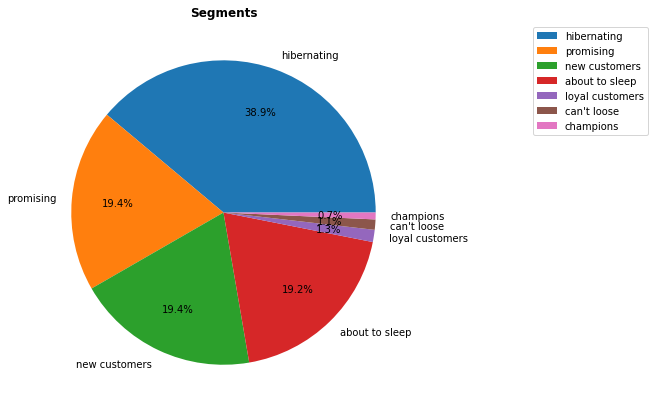

In [16]:
seg = rfm['Segment'].value_counts()

plt.rcParams["figure.figsize"] = (7,7)
plt.pie(seg, labels = seg.index, autopct='%1.1f%%', pctdistance = 0.7)
plt.legend(bbox_to_anchor=(1.3, 1.0), loc='upper left')
plt.title("Segments", fontsize = 12,fontweight = 'bold')
plt.show()

Ce graphique permet de voir qu'une majorité de clients sont dans l'état "hibernating", et qu'il y a peu de clients qui reviennent acheter.

In [17]:
rfm.describe()

,Recency,Frequency,Monetary,R,F,M
count,96096.000000,96096.000000,95856.000000,96096.000000,96096.000000,96096.000000
mean,287.748054,1.032187,158.726917,3.003840,1.124292,3.004776
std,153.423153,0.220200,219.912257,1.415154,0.694065,1.416121
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,163.000000,1.000000,60.640000,2.000000,1.000000,2.000000
50%,268.000000,1.000000,103.802500,3.000000,1.000000,3.000000
75%,397.000000,1.000000,175.300000,4.000000,1.000000,4.000000
max,762.000000,17.000000,13664.080000,5.000000,5.000000,5.000000


## 4. Conclusion <a class="anchor" id="chapter4"></a>

Beaucoup de personnes ne font qu'une commande et on a beaucoup de client en "hibernation".

## 5. Création de fichier csv <a class="anchor" id="chapter5"></a>

Création d'un nouveau dataframe pour pouvoir créer un nouveau fichier "csv". On vérifie que nos données n'ont pas de valeurs manquantes. Si c'est le cas, on va imputer les valeurs manquantes par la moyenne.

In [18]:
tauxRemplissage(rfm)

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM Score,Segment
0,1.0,1.0,1.0,0.997502,1.0,1.0,1.0,1.0,1.0


In [19]:
col = ["Recency", "Frequency", "Monetary"]
imp = SimpleImputer(missing_values=np.nan, strategy="mean", fill_value="missing")
rfm[col] = imp.fit_transform(rfm[col])

In [20]:
df = pd.merge(df[['customer_unique_id', 'customer_city', 'geolocation_lat', "seller_id",
              'geolocation_lng', 'product_category_name_english',
               "order_delivered_customer_date", "order_approved_at"]],
              rfm, on = "customer_unique_id", how = "outer")

In [21]:
df.to_csv('notebooksimulation.csv', index=False)